In [ ]:
# Dataset from https://github.com/xuantrung1803/XSS-Detection


In [13]:
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# 1. Read Data

In [14]:
df = pd.read_csv('XSS_dataset.csv', encoding='utf-8-sig')
df=df[['Sentence','Label']]
df

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0
...,...,...
13681,<img onpointerenter=alert(1)>XSS</img>,1
13682,"<source onbeforepaste=""alert(1)"" contenteditab...",1
13683,"<div draggable=""true"" contenteditable>drag me<...",1
13684,"<li><cite id=""CITEREFDomingos2015"" class=""cita...",0


In [29]:
def get_len(x):
  return len(x.split(' '))
tqdm.pandas()
df['len']=df['Sentence'].progress_apply(lambda x: get_len(x))

100%|██████████| 13686/13686 [00:00<00:00, 540779.89it/s]


In [7]:
# df['len'].plot(kind='bar')

In [30]:
df['len'].mean()

7.4049393540844655

# 2. decode

In [31]:
def decode(X, max_len):
    alphabet = " abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    result = []
    for data in X:
        mat = []
        for ch in data:
            if ch not in alphabet:
                continue
            mat.append(alphabet.index(ch))
        result.append(mat)
    X_char = tf.keras.preprocessing.sequence.pad_sequences(np.array(result, dtype=object), padding='post',
                                                           truncating='post', maxlen=max_len)
    return X_char


In [32]:
data = df['Sentence'].values
label = df['Label'].values

# 3. train and test split

In [34]:
from tensorflow.keras.utils import to_categorical
labels_int=label
labels_bin = to_categorical(labels_int)
print('Shape of label tensor:', labels_bin.shape)

Shape of label tensor: (13686, 2)


In [35]:
x_train1, x_test1, y_train, y_test = train_test_split(
    data, labels_bin, test_size=0.2, random_state=42)
maxlen=100
x_train = decode(x_train1, max_len=maxlen)
x_test = decode(x_test1, max_len=maxlen)


# 4. CNN model

In [49]:
from tensorflow import keras
from tensorflow.keras.models import Model
def Create_CNN(data,maxlen):

  # txt input
  word_input_cnn=keras.layers.Input(shape=(maxlen,),dtype='float64',name="txt_input_cnn")
  x=keras.layers.Embedding(input_dim=100,
                           output_dim=100,
                           input_length=maxlen,
                           name="Embedd_cnn")(word_input_cnn)

  x=keras.layers.Conv1D(filters=64,
                        kernel_size=2,
                        activation='relu',
                        padding="same",
                        name="cov_1")(x)
  x=keras.layers.MaxPool1D(pool_size=(2),name="maxpool1")(x)

  x=keras.layers.Conv1D(filters=128,
                        kernel_size=2,
                        activation='relu',
                        padding="same",
                        name="cov_2")(x)
  x=keras.layers.MaxPool1D(pool_size=(2),name="maxpool2")(x)
  x=keras.layers.Flatten(name='flt_SMP')(x) # sequence max pool

  x =keras.layers.Dense(256,activation="relu",
                                 name="dens_2")(x)
  x =keras.layers.Dropout(0.1)(x)
  output= keras.layers.Dense(2, activation='softmax', name='out')(x)
  model = Model(inputs=word_input_cnn,
                       outputs=output)
  opti=keras.optimizers.Adam(learning_rate=1e-5)
  model.compile(loss='categorical_crossentropy',
                       optimizer=opti,
                       metrics='accuracy')
  return model


In [50]:
CNN_embedding=Create_CNN(data=data,
                         maxlen=maxlen)
CNN_embedding.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 txt_input_cnn (InputLayer)  [(None, 100)]             0         
                                                                 
 Embedd_cnn (Embedding)      (None, 100, 100)          10000     
                                                                 
 cov_1 (Conv1D)              (None, 100, 64)           12864     
                                                                 
 maxpool1 (MaxPooling1D)     (None, 50, 64)            0         
                                                                 
 cov_2 (Conv1D)              (None, 50, 128)           16512     
                                                                 
 maxpool2 (MaxPooling1D)     (None, 25, 128)           0         
                                                                 
 flt_SMP (Flatten)           (None, 3200)              0   

In [51]:
batch_size = 512
num_epoch = 20
model_log = CNN_embedding.fit(x_train,y_train,batch_size=batch_size,
                      epochs=num_epoch,verbose=1,
                      validation_data=(x_test, y_test))


Epoch 1/20
22/22 [==============================] - 4s 75ms/step - loss: 0.6894 - accuracy: 0.5515 - val_loss: 0.6831 - val_accuracy: 0.5409
Epoch 2/20
22/22 [==============================] - 1s 24ms/step - loss: 0.6778 - accuracy: 0.5832 - val_loss: 0.6715 - val_accuracy: 0.5774
Epoch 3/20
22/22 [==============================] - 0s 21ms/step - loss: 0.6655 - accuracy: 0.6362 - val_loss: 0.6588 - val_accuracy: 0.6618
Epoch 4/20
22/22 [==============================] - 0s 14ms/step - loss: 0.6521 - accuracy: 0.7073 - val_loss: 0.6450 - val_accuracy: 0.7290
Epoch 5/20
22/22 [==============================] - 0s 14ms/step - loss: 0.6374 - accuracy: 0.7472 - val_loss: 0.6295 - val_accuracy: 0.7637
Epoch 6/20
22/22 [==============================] - 0s 14ms/step - loss: 0.6207 - accuracy: 0.7889 - val_loss: 0.6125 - val_accuracy: 0.8031
Epoch 7/20
22/22 [==============================] - 0s 14ms/step - loss: 0.6024 - accuracy: 0.8076 - val_loss: 0.5937 - val_accuracy: 0.8035
Epoch 8/20
22

In [39]:
import numpy as np
pred_test=CNN_embedding.predict(x_test)
lbl_pred=np.argmax(pred_test,axis=1).astype(int)
lbl_real=np.argmax(y_test,axis=1).astype(int)

86/86 [==============================] - 0s 3ms/step


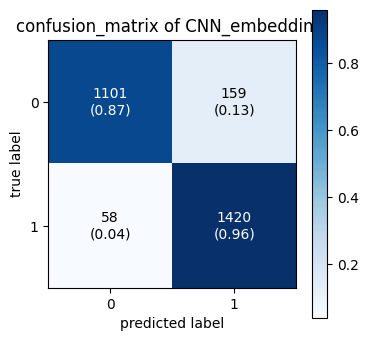

--------------------------------------------------
 accuracy: 0.920745069393718
precision: 0.92463010795815
   recall: 0.9172836522971841
 f1_score: 0.9196544421324855
--------------------------------------------------


In [40]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import auc
import matplotlib.pyplot as plt

n_class=4

classfi_report=classification_report(lbl_real, lbl_pred,output_dict=True)
# save to array
accuracy=accuracy_score(lbl_real, lbl_pred)
precision=classfi_report['macro avg']['precision']
recall= classfi_report['macro avg']['recall']
f1_score=classfi_report['macro avg']['f1-score']
Con_matrix=confusion_matrix(lbl_real, lbl_pred)
fig, ax = plot_confusion_matrix(conf_mat=Con_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(n_class,n_class) )
ax.set_title('confusion_matrix of CNN_embedding ')
plt.show()
print("-"*50)
print(" accuracy: {0}".format(accuracy))
print("precision: {0}".format(precision))
print("   recall: {0}".format(recall))
print(" f1_score: {0}".format(f1_score))
print("-"*50)

# 5. LSTM model

In [60]:
from tensorflow import keras
from tensorflow.keras.models import Model
def Create_LSTM(data,maxlen):


  word_input_cnn=keras.layers.Input(shape=(maxlen,),dtype='float64',name="txt_input_cnn")
  x=keras.layers.Embedding(input_dim=100,
                           output_dim=100,
                           input_length=maxlen,
                           name="Embedd_cnn")(word_input_cnn)
  x= keras.layers.LSTM(16, return_sequences=True)(x)
  x=keras.layers.Dropout(0.5)(x)
  x= keras.layers.LSTM(32, return_sequences=True)(x)
  x=keras.layers.Flatten(name='flt_SMP')(x)
  x =keras.layers.Dense(256,activation="relu",
                                 name="dens_2")(x)
  x =keras.layers.Dropout(0.1)(x)
  output= keras.layers.Dense(2, activation='softmax', name='out')(x)
  model = Model(inputs=word_input_cnn,
                       outputs=output)
  opti=keras.optimizers.Adam(learning_rate=1e-5)
  model.compile(loss='categorical_crossentropy',
                       optimizer=opti,
                       metrics='accuracy')
  return model


In [61]:
LSTM_embedding=Create_LSTM(data=data,
                         maxlen=maxlen)
LSTM_embedding.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 txt_input_cnn (InputLayer)  [(None, 100)]             0         
                                                                 
 Embedd_cnn (Embedding)      (None, 100, 100)          10000     
                                                                 
 lstm_4 (LSTM)               (None, 100, 16)           7488      
                                                                 
 dropout_12 (Dropout)        (None, 100, 16)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 32)           6272      
                                                                 
 flt_SMP (Flatten)           (None, 3200)              0         
                                                                 
 dens_2 (Dense)              (None, 256)               8194

In [62]:
batch_size = 512
num_epoch = 20
model_log = LSTM_embedding.fit(x_train,y_train,batch_size=batch_size,
                      epochs=num_epoch,verbose=1,
                      validation_data=(x_test, y_test))


Epoch 1/20
22/22 [==============================] - 7s 126ms/step - loss: 0.6876 - accuracy: 0.5543 - val_loss: 0.6806 - val_accuracy: 0.5424
Epoch 2/20
22/22 [==============================] - 1s 28ms/step - loss: 0.6759 - accuracy: 0.5883 - val_loss: 0.6682 - val_accuracy: 0.5796
Epoch 3/20
22/22 [==============================] - 0s 15ms/step - loss: 0.6631 - accuracy: 0.6461 - val_loss: 0.6542 - val_accuracy: 0.6822
Epoch 4/20
22/22 [==============================] - 0s 15ms/step - loss: 0.6485 - accuracy: 0.7107 - val_loss: 0.6375 - val_accuracy: 0.7462
Epoch 5/20
22/22 [==============================] - 0s 15ms/step - loss: 0.6309 - accuracy: 0.7487 - val_loss: 0.6185 - val_accuracy: 0.7684
Epoch 6/20
22/22 [==============================] - 0s 22ms/step - loss: 0.6112 - accuracy: 0.7684 - val_loss: 0.5966 - val_accuracy: 0.7736
Epoch 7/20
22/22 [==============================] - 0s 15ms/step - loss: 0.5892 - accuracy: 0.7807 - val_loss: 0.5731 - val_accuracy: 0.7816
Epoch 8/20
2

In [63]:
import numpy as np
pred_test=LSTM_embedding.predict(x_test)
lbl_pred=np.argmax(pred_test,axis=1).astype(int)
lbl_real=np.argmax(y_test,axis=1).astype(int)

86/86 [==============================] - 1s 6ms/step


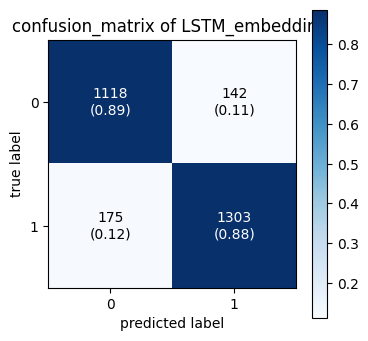

--------------------------------------------------
 accuracy: 0.8842220598977356
precision: 0.8831929714700129
   recall: 0.8844491698348261
 f1_score: 0.8836910658594753
--------------------------------------------------


In [65]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import auc
import matplotlib.pyplot as plt

n_class=4

classfi_report=classification_report(lbl_real, lbl_pred,output_dict=True)
# save to array
accuracy=accuracy_score(lbl_real, lbl_pred)
precision=classfi_report['macro avg']['precision']
recall= classfi_report['macro avg']['recall']
f1_score=classfi_report['macro avg']['f1-score']
Con_matrix=confusion_matrix(lbl_real, lbl_pred)
fig, ax = plot_confusion_matrix(conf_mat=Con_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(n_class,n_class) )
ax.set_title('confusion_matrix of LSTM_embedding ')
plt.show()
print("-"*50)
print(" accuracy: {0}".format(accuracy))
print("precision: {0}".format(precision))
print("   recall: {0}".format(recall))
print(" f1_score: {0}".format(f1_score))
print("-"*50)

# 6.CNN_RF

In [67]:
def get_feature_extraction_batch(layer_extract,data,dim_ext):
    N=data.shape[0]
    lst=list(range(N))
    batch_idx=[lst[i:i + 512 ] for i in range(0, N, 512 )]
    feature_extract=np.array([]).reshape(0,dim_ext)
    for item_idx in batch_idx:
      feature_new=layer_extract(data[item_idx])
      feature_extract=np.concatenate((feature_extract,feature_new),axis=0)
    return feature_extract

In [68]:
# feature extraction
extract_layer_CNN = tf.keras.models.Model(inputs=CNN_embedding.inputs,
                                          outputs=CNN_embedding.get_layer(name="flt_SMP").output)

dim_cnn=CNN_embedding.get_layer(name="flt_SMP").output.shape[1]
feature_Train=get_feature_extraction_batch(extract_layer_CNN,x_train,dim_cnn)
feature_Test=get_feature_extraction_batch(extract_layer_CNN,x_test,dim_cnn)


In [76]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(max_depth=10, random_state=0)
RF_model.fit(feature_Train,np.argmax(y_train,axis=1))

RandomForestClassifier(max_depth=10, random_state=0)

In [77]:
import numpy as np
pred_test=RF_model.predict(feature_Test)
lbl_pred=pred_test.astype(int)
lbl_real=np.argmax(y_test,axis=1).astype(int)

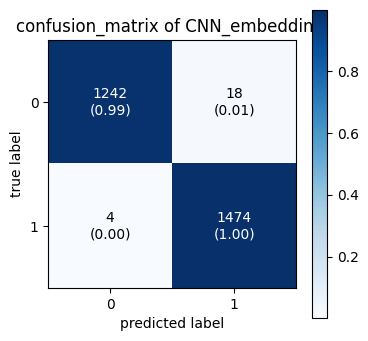

--------------------------------------------------
 accuracy: 0.9919649379108838
precision: 0.9923626919816335
   recall: 0.9915039628842065
 f1_score: 0.9919068310129762
--------------------------------------------------


In [59]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import auc
import matplotlib.pyplot as plt

n_class=4

classfi_report=classification_report(lbl_real, lbl_pred,output_dict=True)
# save to array
accuracy=accuracy_score(lbl_real, lbl_pred)
precision=classfi_report['macro avg']['precision']
recall= classfi_report['macro avg']['recall']
f1_score=classfi_report['macro avg']['f1-score']
Con_matrix=confusion_matrix(lbl_real, lbl_pred)
fig, ax = plot_confusion_matrix(conf_mat=Con_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(n_class,n_class) )
ax.set_title('confusion_matrix of CNN_RF ')
plt.show()
print("-"*50)
print(" accuracy: {0}".format(accuracy))
print("precision: {0}".format(precision))
print("   recall: {0}".format(recall))
print(" f1_score: {0}".format(f1_score))
print("-"*50)

# 7.LSTM_RF

In [78]:
def get_feature_extraction_batch(layer_extract,data,dim_ext):
    N=data.shape[0]
    lst=list(range(N))
    batch_idx=[lst[i:i + 512 ] for i in range(0, N, 512 )]
    feature_extract=np.array([]).reshape(0,dim_ext)
    for item_idx in batch_idx:
      feature_new=layer_extract(data[item_idx])
      feature_extract=np.concatenate((feature_extract,feature_new),axis=0)
    return feature_extract

In [79]:
# feature extraction
extract_layer_LSTM = tf.keras.models.Model(inputs=LSTM_embedding.inputs,
                                          outputs=LSTM_embedding.get_layer(name="flt_SMP").output)

dim_cnn=LSTM_embedding.get_layer(name="flt_SMP").output.shape[1]
feature_Train=get_feature_extraction_batch(extract_layer_LSTM,x_train,dim_cnn)
feature_Test=get_feature_extraction_batch(extract_layer_LSTM,x_test,dim_cnn)


In [80]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(max_depth=10, random_state=0)
RF_model.fit(feature_Train,np.argmax(y_train,axis=1))

RandomForestClassifier(max_depth=10, random_state=0)

In [81]:
import numpy as np
pred_test=RF_model.predict(feature_Test)
lbl_pred=pred_test.astype(int)
lbl_real=np.argmax(y_test,axis=1).astype(int)

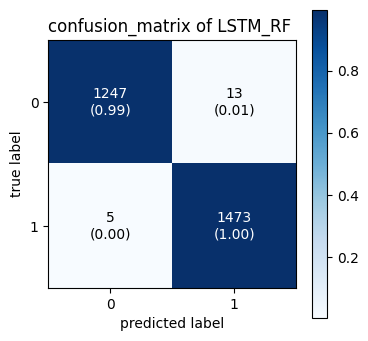

--------------------------------------------------
 accuracy: 0.9934258582907232
precision: 0.9936290360725666
   recall: 0.9931497948750994
 f1_score: 0.9933807602052658
--------------------------------------------------


In [82]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import auc
import matplotlib.pyplot as plt

n_class=4

classfi_report=classification_report(lbl_real, lbl_pred,output_dict=True)
# save to array
accuracy=accuracy_score(lbl_real, lbl_pred)
precision=classfi_report['macro avg']['precision']
recall= classfi_report['macro avg']['recall']
f1_score=classfi_report['macro avg']['f1-score']
Con_matrix=confusion_matrix(lbl_real, lbl_pred)
fig, ax = plot_confusion_matrix(conf_mat=Con_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                figsize=(n_class,n_class) )
ax.set_title('confusion_matrix of LSTM_RF ')
plt.show()
print("-"*50)
print(" accuracy: {0}".format(accuracy))
print("precision: {0}".format(precision))
print("   recall: {0}".format(recall))
print(" f1_score: {0}".format(f1_score))
print("-"*50)